## Overlaps

The overlap is an inner-product between two waveforms. It is somewhat akin to the inner product between two vectors:

$$
A\cdot B = |A||B|\cos\theta
$$

In this case, we'll call the two waveforms $h_1$ and $h_2$. In the frequency domain, the waveforms are a function of frequency, e.g. ($\tilde{h}(f)$ is the Fourier transform of a waveform time series. We will assume that we can obtain $\tilde{h}(f)$ without first referencing a time series.

For a finite vector space (e.g. cartesian $\hat{x}, \hat{y}, \hat{z}$) the inner product is defined as:

$$
A\cdot B = A_xB_x + A_yB_y + A_zB_z
$$

In the gravitational wave case, since the variable here is $f$ the frequency, the inner product is actually over an infinite space (the space of frequencies) and we use an integral:

$$
\tilde{h}_1(f)\cdot\tilde{h}_2(f) \equiv \int \tilde{h}_1(f) \tilde{h}_2(f)^{\star} df
$$

The $\tilde{h}(f)$ are complex quantities (e.g. having a real and imaginary part) and so the inner product requires a conjugation (the h^{\star}) in order to be completely specified.

The overlap itself adds a weighting to each frequency component of the waveforms indicating how "sensitive" the detector is to that frequency. The sensitvity function is the power spectral density $S(f)$. So, the overlap is proportional to:

$$
\left(\tilde{h}_1(f)|\tilde{h}_2(f)\right) \propto 4 \int_0^{\infty} \frac{\tilde{h}_1(f) \tilde{h}_2(f)^{\star}}{S(f)} df
$$

This qunatity is like the right hand side of the first equation above, but we want a number between one and zero (the inner product in the frequency space is positive definite by definition, so $A\cdot B$ could be betweeen -1 and 1, but the overlap has to be positive. To accomplish this in the first equation, we'd divide the sum  in the second equation by the norm of the vetctors (from the right hand side of the first equation). In the waveform case, we divide the inner product above by the inner product (the norm) of each waveform with itself. So, in full:

$$
\mathcal{O}_{12} = \frac{(\tilde{h}_1|\tilde{h}_2)}{\sqrt{(\tilde{h}_1|\tilde{h}_1)(\tilde{h}_2|\tilde{h}_2)}}
$$

In [3]:
from __future__ import division

import numpy

import lal
import lalsimulation
from lalinference.rapid_pe import lalsimutils

import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Bounds of the integral -- we consider anything outside of these bounds to be effectively zero because of the
# waveform terminating or the detector sensitivity being too small
flow = 30
fmax = fnyq = 2048

# We're actually doing a numerical integral so df -> \delta f
delta_f = 0.125

# Sensitivity function
# FIXME: Import PSD
#psd =

# Define the overlap object
olap = lalsimutils.Overlap(flow, fmax, fnyq, delta_f)

In [2]:
# Calculate the overlap between two identical waveforms


# Generate waveforms
# This function takes in a bunch of parameters (which we will draw from the posterior distributions) and generates the
# frequency domain waveforms
# Intrinsic parameters:
# component masses in kg
m1, m2 = 30 * lal.MSUN_SI, 30 * lal.MSUN_SI
# component spins (Cartesian, normalized to be unitless)
s1x, s1y, s1z = 0.0, 0.0, 0.0
s2x, s2y, s2z = 0.0, 0.0, 0.0

# Extrinsic parameters
# coalescence phase and polarization angle
coa_phase, polarization_angle = 0.0, 0.0
# sky position
ra, dec = 0.0, 0.0
# distance in m and inclination
dist, incl = 1e6 * lal.PC_SI, 0.0

# waveform model to use
approx1 = lalsimulation.TaylorF2

hpf, hxf = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                            m1, m2,
                            s1x, s1y, s1z,
                            s2x, s2y, s2z,
                            flow, fmax, flow,
                            dist, 0.0, incl,
                            0.0, 0.0, None, None,
                            -1, 0, approx1)

# FIXME: Apply more extrinsic parameters (if necessary)

# For convenience, we'll reuse hpf and redefine to be h1
hpf.data.data += hxf.data.data
h1 = hpf

# This is (h_1|h_1)
norm1 = olap.ip(h1, h1)

# ...aaaaand do the overlap
# with itself to check if we get one
olap.ip(h1, h1) / numpy.sqrt(norm1 * norm1)

1.0

In [3]:
def overlap(m1, m2, target):
    
    """
    Calculate the overlap of a waveform with masses m1 and m2
    to a target waveform with identical spin and extrinsic parameters.
    
    m1 -- mass of larger compact object in solar masses
    
    m2 -- mass of smaller compact object in solar masses
    
    target -- iterable of two masses for the target waveform in solar masses
    """
    
    # Calculate target waveform
    m1_target, m2_target = target[0] * lal.MSUN_SI, target[1] * lal.MSUN_SI
    
    # component spins (Cartesian, normalized to be unitless)
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0

    # Extrinsic parameters
    # coalescence phase and polarization angle
    coa_phase, polarization_angle = 0.0, 0.0
    # sky position
    ra, dec = 0.0, 0.0
    # distance in m and inclination
    dist, incl = 1e6 * lal.PC_SI, 0.0

    # waveform model to use
    approx1 = lalsimulation.IMRPhenomPv2  #TaylorF2  -- Change this for funsies

    hpf_target, hxf_target = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1_target, m2_target,
                                s1x, s1y, s1z,
                                s2x, s2y, s2z,
                                flow, fmax, flow,
                                dist, 0.0, incl,
                                0.0, 0.0, None, None,
                                -1, 0, approx1)
    # For convenience, we'll reuse hpf and redefine to be h1
    hpf_target.data.data += hxf_target.data.data
    h_target = hpf_target
    
    
    # Calculate the second waveform
    m1 *= lal.MSUN_SI
    m2 *= lal.MSUN_SI

    # waveform model to use
    approx2 = lalsimulation.IMRPhenomPv2  #TaylorF2

    hpf, hxf = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1, m2,
                                s1x, s1y, s1z,
                                s2x, s2y, s2z,
                                flow, fmax, flow,
                                dist, 0.0, incl,
                                0.0, 0.0, None, None,
                                -1, 0, approx2)
    
    # For convenience, we'll reuse hpf and redefine to be h1
    hpf.data.data += hxf.data.data
    h1 = hpf
    
    # Return the overlap
    return olap.ip(h1, h_target) / numpy.sqrt(olap.ip(
            h1, h1) * olap.ip(h_target, h_target))

In [4]:
def overlap_diff(masses, target):
    """Calculate the difference between an overlap and the maximum possible overlap (1)."""
    return 1 - overlap(masses[0], masses[1], target)

In [5]:
# Calculate overlap for each pair of m1 and m2 in a grid, compared to a target value

# Set target value to compare waveforms to
target = (30., 20.)  # solar masses -- larger value first

# Iterate over all pairs of m1 and m2 for a set range where m2 <= m1
m1s = []
m2s = []
overlaps = []
for m1 in numpy.arange(1., 50., 1.):
    for m2 in numpy.arange(1., m1, 1.):
        m1s.append(m1)
        m2s.append(m2)
        
        # Calculate overlap at each point
        overlaps.append(overlap(m1, m2, target))
        
m1s = numpy.asarray(m1s)
m2s = numpy.asarray(m2s)
overlaps = numpy.asarray(overlaps)


array([  2.,   3.,   3., ...,  49.,  49.,  49.])

In [6]:
# For the grid of overlaps, find the highest overlap
optimized_value = minimize(overlap_diff, [32, 25], method='Nelder-Mead', args=(target,))  
optimized_value

# !!! - this optimization method is highly dependent on the guess

 final_simplex: (array([[ 22.56598119,  26.87135965],
       [ 22.56595299,  26.87138201],
       [ 22.56589983,  26.8714407 ]]), array([ 0.00032991,  0.00034202,  0.00034202]))
           fun: 0.00032991313544739054
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 42
        status: 0
       success: True
             x: array([ 22.56598119,  26.87135965])

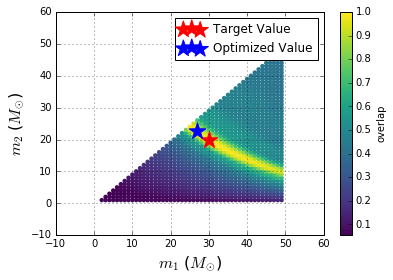

In [7]:
# Make a plot of m1 vs. m2 colored by overlap 
plt.scatter(m1s, m2s, c=overlaps, cmap='viridis', edgecolors='None')
plt.colorbar(label='overlap')
plt.scatter(target[0], target[1], color='r', marker='*', s=300, label='Target Value')
plt.scatter(max(optimized_value.x), min(optimized_value.x), color='b', marker='*', s=300, label='Optimized Value')
plt.xlabel(r'$m_{1}$ ($M_{\odot}$)', fontsize=16)
plt.ylabel(r'$m_{2}$ ($M_{\odot}$)', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [10]:
def overlap_diff_mceta(masses, target):
    """
    Calculate the difference between an overlap and the maximum possible overlap (1)
    given chirp mass and mass ratio.
    
    masses - iterable where first entry is the chirp mass and second entry is eta
    """
    m1, m2 = lalsimutils.m1m2(masses[0], masses[1])
    #print m1, m2
    return 1 - overlap(m1, m2, target)

In [9]:
# Calculate eta, M_chirp, and overlap for each m1-m2 pair
m_chirps = []
etas = []
overlaps_mceta = []
for i, m1 in enumerate(m1s):
    #print i, m1, m2s[i]
    m2 = m2s[i]
    m_chirp, eta = lalsimutils.Mceta(m1, m2)
    eta = (m1 * m2) / (m1 + m2)**2
    #print m1, m2, m_chirp, eta
    m_chirps.append(m_chirp)
    etas.append(eta)
    
    #Calculate overlap at each point
    overlaps_mceta.append(overlap(m1, m2, target))
    
m_chirps = numpy.asarray(m_chirps)
etas = numpy.asarray(etas)
overlaps_mceta = numpy.asarray(overlaps_mceta)

In [11]:
# For the grid of overlaps, find the highest overlap
#lalsimutils.m1m2(21.23, 0.67)
optimized_value_mceta = minimize(overlap_diff_mceta, [20, 0.2], method='TNC', args=(target,), bounds=[(0.5, 50), (0, 0.25)])  
optimized_value_mceta

# !!! - this optimization method is highly dependent on the guess

     fun: 0.01186988425122848
     jac: array([-0.05875305,  1.30034895])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 19
     nit: 2
  status: 1
 success: True
       x: array([ 20.02976036,   0.19997918])

0.24
0.24


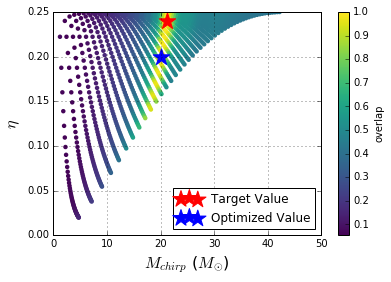

In [13]:
# Make a plot of m_chirp vs. eta colored by overlap 
plt.scatter(m_chirps, etas, c=overlaps_mceta, cmap='viridis', edgecolors='None')
plt.colorbar(label='overlap')

# Include the target point
mc_target, eta_target = lalsimutils.Mceta(target[0], target[1])  
plt.scatter(mc_target, eta_target, color='r', marker='*', s=300, label='Target Value')

# Include the optimized point
plt.scatter(optimized_value_mceta.x[0], optimized_value_mceta.x[1], color='b', marker='*', s=300, label='Optimized Value')


plt.xlabel(r'$M_{chirp}$ ($M_{\odot}$)', fontsize=16)
plt.ylabel(r'$\eta$', fontsize=16)
plt.xlim([0, 50])
plt.ylim([0, 0.25])
plt.legend(loc=4)
plt.grid()
plt.show()

In [19]:
# Make a plot of eta vs. M_chirp colored by overlap where I grid by eta and M_chirp, and not m1 and m2

# Iterate over all pairs of M_chirp and eta for a set range where m2 <= m1
mcs2 = []
etas2 = []
overlaps_mceta2 = []
for mc in numpy.arange(lalsimutils.mchirp(1., 1.), lalsimutils.mchirp(50., 50.), 1.):
    # FIX ME: iterate over a more physically feasible space; which etas are possible for which mchirps?
    for eta in numpy.arange(0.01, 0.25, 0.005):  
        mcs2.append(mc)
        etas2.append(eta)
        
        # Calculate overlap at each point
        m1, m2 = lalsimutils.m1m2(mc, eta)
        overlaps_mceta2.append(overlap(m1, m2, target))
        
mcs2 = numpy.asarray(mcs2)
etas2 = numpy.asarray(etas2)
overlaps_mceta2 = numpy.asarray(overlaps_mceta2)

In [20]:
optimized_value_mceta2 = minimize(overlap_diff_mceta, [20, 0.2], method='TNC', args=(target,), bounds=[(0.5, 50), (0, 0.25)])  
optimized_value_mceta2

     fun: 0.0078967741876347919
     jac: array([ -1.73361325e-04,  -2.76630097e-01])
 message: 'Linear search failed'
    nfev: 36
     nit: 3
  status: 4
 success: False
       x: array([ 20.17856222,   0.19987512])

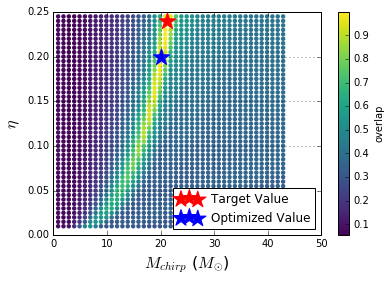

In [21]:
# Make a plot of m_chirp vs. eta colored by overlap 
plt.scatter(mcs2, etas2, c=overlaps_mceta2, cmap='viridis', edgecolors='None')
plt.colorbar(label='overlap')

# Include the target point
mc_target, eta_target = lalsimutils.Mceta(target[0], target[1])  
plt.scatter(mc_target, eta_target, color='r', marker='*', s=300, label='Target Value')

# Include the optimized point
plt.scatter(optimized_value_mceta2.x[0], optimized_value_mceta2.x[1], color='b', marker='*', s=300, label='Optimized Value')

plt.xlabel(r'$M_{chirp}$ ($M_{\odot}$)', fontsize=16)
plt.ylabel(r'$\eta$', fontsize=16)
plt.xlim([0, 50])
plt.ylim([0, 0.25])
plt.legend(loc=4)
plt.grid()
plt.show()

## Play Around With Spin

In [4]:
def overlap_spin(s1z, s2z, target):
    
    """
    Calculate the overlap of a waveform with spins s1z and s2z
    to a target waveform with identical masses and extrinsic parameters.
    
    s1z -- spin component on z-axis for larger compact object
    
    s2z -- spin component on z-axis for smaller compact object
    
    target -- iterable of two spins for the target waveform 
    """
    
    # Calculate target waveform
    m1, m2 = 30 * lal.MSUN_SI, 30 * lal.MSUN_SI
    
    # x- and y-axis spins set to zero
    s1x, s1y, s1z_target = 0.0, 0.0, target[0]
    s2x, s2y, s2z_target = 0.0, 0.0, target[1]

    # Extrinsic parameters
    # coalescence phase and polarization angle
    coa_phase, polarization_angle = 0.0, 0.0
    # sky position
    ra, dec = 0.0, 0.0
    # distance in m and inclination
    dist, incl = 1e6 * lal.PC_SI, 0.0

    # waveform model to use
    approx1 = lalsimulation.IMRPhenomPv2  #TaylorF2  -- Change this for funsies

    hpf_target, hxf_target = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1, m2,
                                s1x, s1y, s1z_target,
                                s2x, s2y, s2z_target,
                                flow, fmax, flow,
                                dist, 0.0, incl,
                                0.0, 0.0, None, None,
                                -1, 0, approx1)
    # For convenience, we'll reuse hpf and redefine to be h1
    hpf_target.data.data += hxf_target.data.data
    h_target = hpf_target
    
    
    # Calculate the second waveform
    approx2 = lalsimulation.IMRPhenomPv2  #TaylorF2

    hpf, hxf = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1, m2,
                                s1x, s1y, s1z,
                                s2x, s2y, s2z,
                                flow, fmax, flow,
                                dist, 0.0, incl,
                                0.0, 0.0, None, None,
                                -1, 0, approx2)
    
    # For convenience, we'll reuse hpf and redefine to be h1
    hpf.data.data += hxf.data.data
    h1 = hpf
    
    # Return the overlap
    return olap.ip(h1, h_target) / numpy.sqrt(olap.ip(
            h1, h1) * olap.ip(h_target, h_target))

In [12]:
# Make a plot of s2z vs. s1z colored by overlap 

target_spin = (-1, 0.)

# Iterate over all pairs of s1z and s2z for a set range where m2 <= m1
s1z_array = []
s2z_array = []
overlaps_spin = []
for s1z in numpy.arange(-1, 1, 0.05):
    for s2z in numpy.arange(-1, 1, 0.05):  
        s1z_array.append(s1z)
        s2z_array.append(s2z)
        
        # Calculate overlap at each point
        overlaps_spin.append(overlap_spin(s1z, s2z, target_spin))
        
s1z_array = numpy.asarray(s1z_array)
s2z_array = numpy.asarray(s2z_array)
overlaps_spin = numpy.asarray(overlaps_spin)

In [8]:
def overlap_diff_spin(spins, target):
    """Calculate the difference between an overlap and the maximum possible overlap (1) given spins."""
    return 1 - overlap_spin(spins[0], spins[1], target)

In [13]:
# For the grid of overlaps, find the highest overlap
optimized_value_spin = minimize(overlap_diff_spin, [0.1, -0.2], method='TNC', args=(target_spin,))  
optimized_value_spin


RuntimeError: Input domain error

In [ ]:
# Make a plot of m_chirp vs. eta colored by overlap 
plt.scatter(s1z_array, s2z_array, c=overlaps_spin, cmap='viridis', edgecolors='None')
plt.colorbar(label='overlap')

# Include the target point
plt.scatter(target_spin[0], target_spin[1], color='r', marker='*', s=300, label='Target Value')

# Include the optimized point
plt.scatter(optimized_value_spin.x[0], optimized_value_spin.x[1], color='b', marker='*', s=300, label='Optimized Value')

plt.xlabel(r'$s_{1, z}$', fontsize=16)
plt.ylabel(r'$\eta$', fontsize=16)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.legend(loc=4)
plt.grid()
plt.show()